In [ ]:
import pandas as pd
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
from tqdm import tqdm
import argparse
import glob
import xml.etree.ElementTree as ET
import cv2
import ast
import numpy as np


import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as immg

import random

import torch

import torchvision
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


import warnings
warnings.filterwarnings("ignore")

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path_an = "/content/drive/MyDrive/PCB DEFECT DATASET/PCB_DATASET/Annotations"
print(path_an)

/content/drive/MyDrive/PCB DEFECT DATASET/PCB_DATASET/Annotations


In [ ]:
dataset = {
            "xmin":[],
            "ymin":[],
            "xmax":[],
            "ymax":[],
            "class":[],
            "file":[],
            "width":[],
            "height":[],
           }
all_files = []
for path, subdirs, files in os.walk(path_an):
#     print([path, subdirs, files])
    for name in files:
        all_files.append(os.path.join(path, name))

# print(all_files)
print(type(dataset))
print(dataset)

<class 'dict'>
{'xmin': [], 'ymin': [], 'xmax': [], 'ymax': [], 'class': [], 'file': [], 'width': [], 'height': []}


In [ ]:
for anno in all_files:
    # print(anno)
    tree = ET.parse(anno)

    for elem in tree.iter():
        # print(elem)

        if 'size' in elem.tag:
            # print('[size] in elem.tag ==> list(elem)\n'), print(list(elem))
            for attr in list(elem):
                if 'width' in attr.tag:
                    width = int(round(float(attr.text)))
                if 'height' in attr.tag:
                    height = int(round(float(attr.text)))

        if 'object' in elem.tag:
            # print('[object] in elem.tag ==> list(elem)\n'), print(list(elem))
            for attr in list(elem):

                # print('attr = %s\n' % attr)
                if 'name' in attr.tag:
                    name = attr.text
                    dataset['class']+=[name]
                    dataset['width']+=[width]
                    dataset['height']+=[height]
                    dataset['file']+=[anno.split('/')[-1][0:-4]]

                if 'bndbox' in attr.tag:
                    for dim in list(attr):
                        if 'xmin' in dim.tag:
                            xmin = int(round(float(dim.text)))
                            dataset['xmin']+=[xmin]
                        if 'ymin' in dim.tag:
                            ymin = int(round(float(dim.text)))
                            dataset['ymin']+=[ymin]
                        if 'xmax' in dim.tag:
                            xmax = int(round(float(dim.text)))
                            dataset['xmax']+=[xmax]
                        if 'ymax' in dim.tag:
                            ymax = int(round(float(dim.text)))
                            dataset['ymax']+=[ymax]

In [ ]:
data=pd.DataFrame(dataset)
data

xmin  ymin  xmax  ymax         class                file  width  height
0     1684   354  1723   385  open_circuit  01_open_circuit_19   3034    1586
1      713  1000   738  1027  open_circuit  01_open_circuit_19   3034    1586
2     2432  1173  2462  1203  open_circuit  01_open_circuit_19   3034    1586
3      580  1083   605  1110  open_circuit  01_open_circuit_13   3034    1586
4      443   904   473   935  open_circuit  01_open_circuit_13   3034    1586
...    ...   ...   ...   ...           ...                 ...    ...     ...
2948   452   235   576   345          spur          11_spur_08   2282    2248
2949   307   581   409   701          spur          11_spur_08   2282    2248
2950  1680  1611  1802  1690          spur          11_spur_08   2282    2248
2951  1181   837  1281   908          spur          11_spur_08   2282    2248
2952  1275   332  1412   425          spur          11_spur_08   2282    2248

[2953 rows x 8 columns]

In [ ]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
train, test = train_test_split(data, shuffle=True, test_size=0.2, random_state=34)

In [ ]:
train.shape, test.shape

((2362, 8), (591, 8))

In [ ]:
train.head()

xmin  ymin  xmax  ymax            class                   file  width  \
1838  1432  1591  1489  1665       mouse_bite       11_mouse_bite_08   2282   
2149  1960  1323  2018  1392     missing_hole     12_missing_hole_10   2529   
1784  2270  1523  2333  1570       mouse_bite       05_mouse_bite_06   2544   
1042  2151  1063  2247  1121  spurious_copper  12_spurious_copper_06   2529   
1992  1413   648  1463   699     missing_hole     09_missing_hole_06   2775   

      height  
1838    2248  
2149    2530  
1784    2156  
1042    2530  
1992    2159

In [ ]:
test.head()

xmin  ymin  xmax  ymax            class                   file  width  \
90     559   504   621   566     open_circuit     04_open_circuit_13   3056   
1315  1463  1565  1520  1655  spurious_copper  11_spurious_copper_03   2282   
1244  2343  1122  2467  1181  spurious_copper  01_spurious_copper_12   3034   
1572   307  1380   352  1454       mouse_bite       06_mouse_bite_09   2868   
1515  2217   401  2273   475       mouse_bite       12_mouse_bite_02   2529   

      height  
90      2464  
1315    2248  
1244    1586  
1572    2316  
1515    2530

In [ ]:
classes_la = {"missing_hole": 0, "mouse_bite": 1, "open_circuit":2, "short": 3, 'spur': 4,'spurious_copper':5}

train["class"] = train["class"].apply(lambda x: classes_la[x])
test["class"] = test["class"].apply(lambda x: classes_la[x])

In [ ]:
train.head()

xmin  ymin  xmax  ymax  class                   file  width  height
1838  1432  1591  1489  1665      1       11_mouse_bite_08   2282    2248
2149  1960  1323  2018  1392      0     12_missing_hole_10   2529    2530
1784  2270  1523  2333  1570      1       05_mouse_bite_06   2544    2156
1042  2151  1063  2247  1121      5  12_spurious_copper_06   2529    2530
1992  1413   648  1463   699      0     09_missing_hole_06   2775    2159

In [ ]:
test.head()

xmin  ymin  xmax  ymax  class                   file  width  height
90     559   504   621   566      2     04_open_circuit_13   3056    2464
1315  1463  1565  1520  1655      5  11_spurious_copper_03   2282    2248
1244  2343  1122  2467  1181      5  01_spurious_copper_12   3034    1586
1572   307  1380   352  1454      1       06_mouse_bite_09   2868    2316
1515  2217   401  2273   475      1       12_mouse_bite_02   2529    2530

In [ ]:
df = train.copy()

df_grp = df.groupby(['file'])
print(df_grp)

In [ ]:
df_grp.size()

file
01_missing_hole_01       3
01_missing_hole_02       3
01_missing_hole_03       3
01_missing_hole_04       3
01_missing_hole_05       4
                        ..
12_spurious_copper_06    4
12_spurious_copper_07    4
12_spurious_copper_08    3
12_spurious_copper_09    3
12_spurious_copper_10    5
Length: 688, dtype: int64

In [ ]:
image_name = '01_missing_hole_02'
image_group = df_grp.get_group(image_name)
print(image_group)

      xmin  ymin  xmax  ymax  class                file  width  height
1980  1506   802  1559   856      0  01_missing_hole_02   3034    1586
1978  2584   232  2650   298      0  01_missing_hole_02   3034    1586
1979  2366   803  2406   860      0  01_missing_hole_02   3034    1586


In [ ]:
bbox = image_group.loc[:,['xmin', 'ymin', 'xmax', 'ymax']]
print([bbox, type(bbox)])

[      xmin  ymin  xmax  ymax
1980  1506   802  1559   856
1978  2584   232  2650   298
1979  2366   803  2406   860, <class 'pandas.core.frame.DataFrame'>]


In [ ]:
def plot_image(image_name):
    print(image_name)
    image_group = df_grp.get_group(image_name)
    bbox = image_group.loc[:,['xmin', 'ymin', 'xmax', 'ymax']]
    path = "/content/drive/MyDrive/PCB DEFECT DATASET/PCB_DATASET/images/"

    # Memperbaiki kesalahan menggunakan image_name
    if "missing" in image_name.split('_'):
        path += 'Missing_hole/'
    if "mouse" in image_name.split('_'):
        path += 'Mouse_bite/'
    if "open" in image_name.split('_'):
        path += 'Open_circuit/'
    if "short" in image_name.split('_'):
        path += 'Short/'
    if "spur" in image_name.split('_'):
        path += 'Spur/'
    if "spurious" in image_name.split('_'):
        path += 'Spurious_copper/'

    # Menambahkan ekstensi file pada path
    img = immg.imread(path + image_name + '.jpg')

    fig, ax = plt.subplots(figsize=(18, 10))
    ax.imshow(img, cmap='binary')
    for i in range(len(bbox)):
        box = bbox.iloc[i].values
        print(box)
        x, y, w, h = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = matplotlib.patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none',)
        ax.add_patch(rect)
    plt.show()




01_missing_hole_01
[1726  794 1797  854]
[2459 1274 2530 1329]
[1613  334 1679  396]


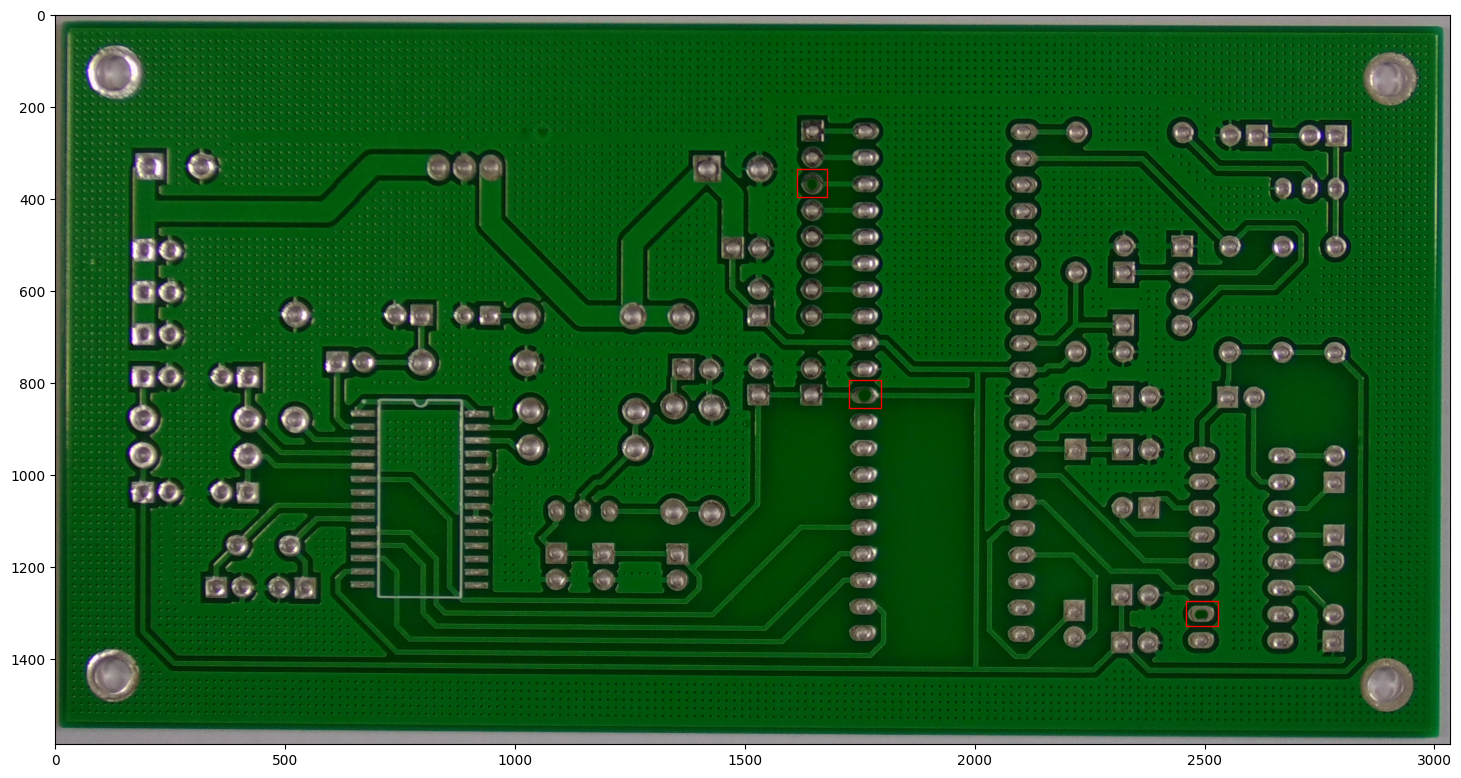

In [ ]:
name = '01_missing_hole_01'
plot_image(name)

04_short_15
[2070  599 2188  721]
[2581  982 2699 1102]


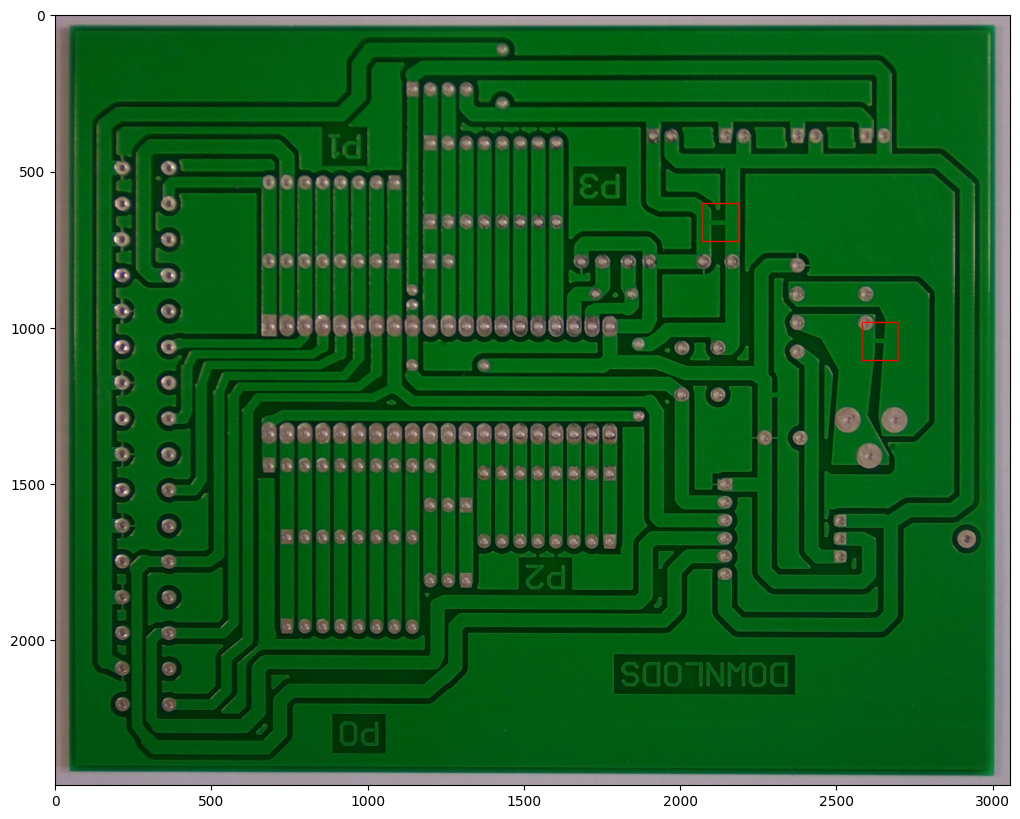

In [ ]:
name = train.file[500]
plot_image(name)

09_open_circuit_04
[ 784 1124  826 1163]
[1137  731 1172  772]
[1412 1127 1455 1172]
[1863  599 1897  643]
[2077  776 2149  830]


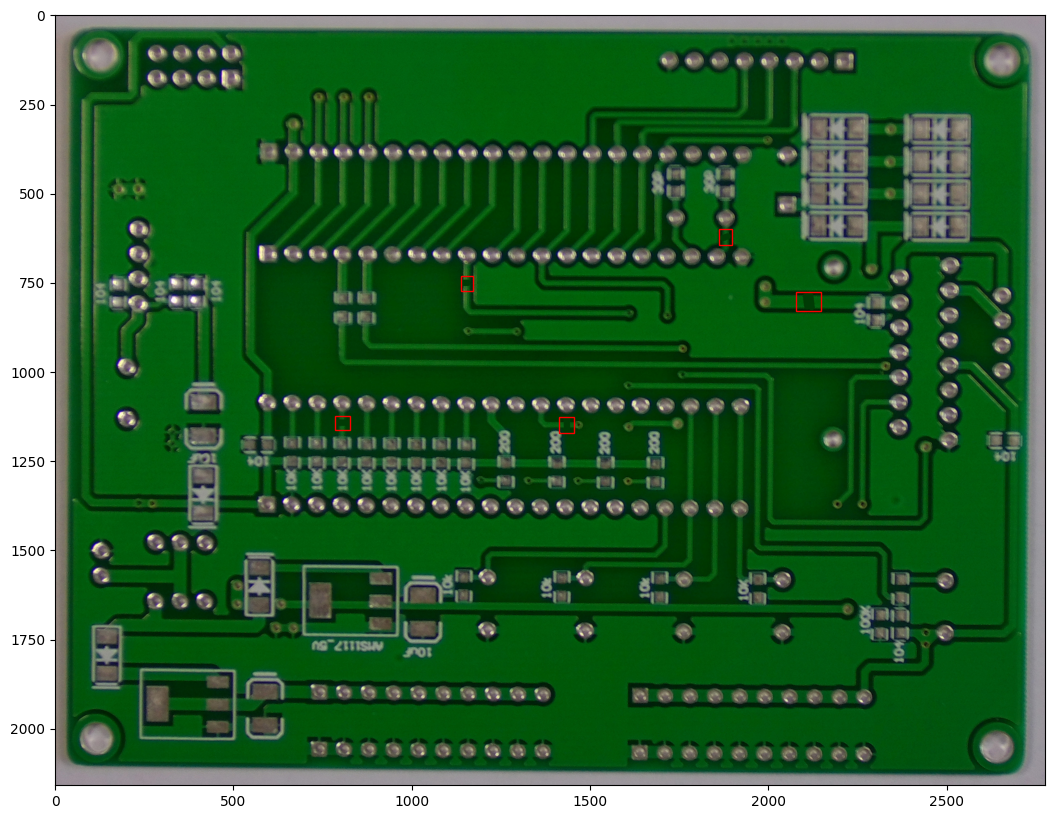

In [ ]:
name = train.file[100]
plot_image(name)

05_open_circuit_09
[1616 1858 1666 1905]
[2245 1360 2308 1412]
[2132 1547 2193 1592]


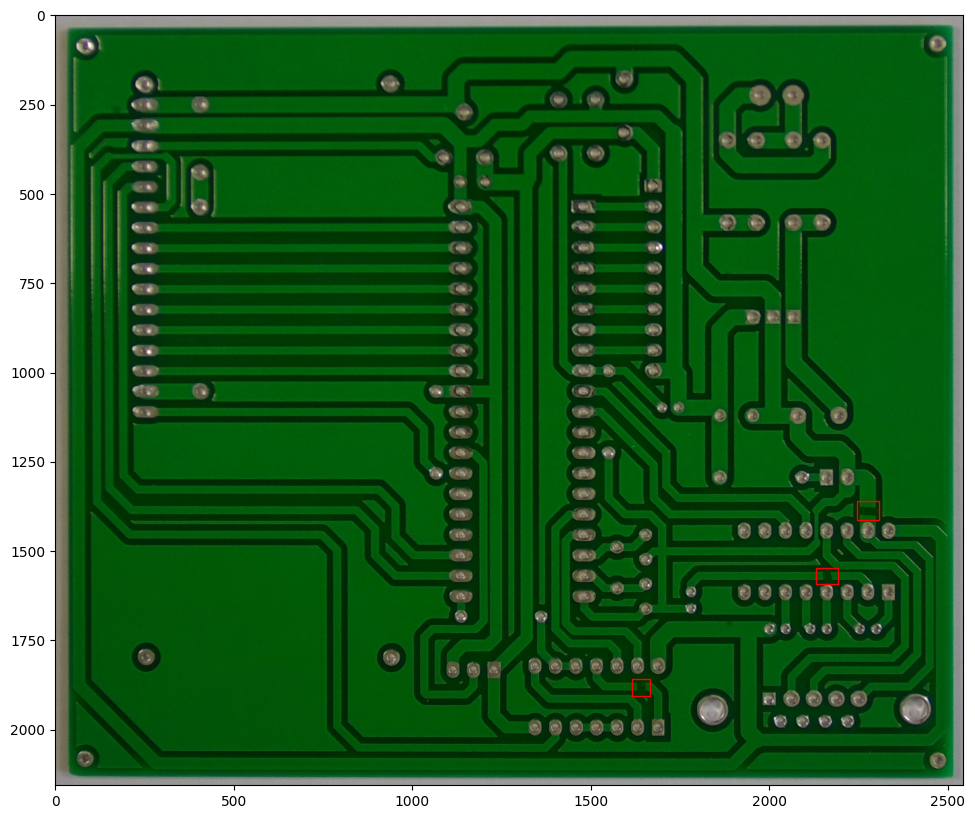

In [ ]:
name = train.file[105]
plot_image(name)

In [ ]:
class fcbData(object):
    def __init__(self, df, IMG_DIR, transforms):
        self.df = df
        self.img_dir = IMG_DIR
        self.image_ids = self.df['file'].unique().tolist()
        self.transforms = transforms

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        a = ''
        if "missing" in image_id.split('_'):
            a = 'Missing_hole/'
        elif "mouse" in image_id.split('_'):
            a = 'Mouse_bite/'
        elif "open" in image_id.split('_'):
            a = 'Open_circuit/'
        elif "short" in image_id.split('_'):
            a = 'Short/'
        elif "spur" in image_id.split('_'):
            a = 'Spur/'
        elif "spurious" in image_id.split('_'):
            a = 'Spurious_copper/'
        image_values = self.df[self.df['file'] == image_id]
        image = cv2.imread(self.img_dir+a+image_id+".jpg",cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = image_values[['xmin', 'ymin', 'xmax', 'ymax']].to_numpy()
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        labels = image_values["class"].values
        labels = torch.tensor(labels)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([idx])
        target['area'] = torch.as_tensor(area, dtype=torch.float32)
        target['iscrowd'] = torch.zeros(len(classes_la), dtype=torch.int64)

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }

            sample = self.transforms(**sample)
            image = sample['image']
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return torch.tensor(image), target, image_id

In [ ]:
def get_train_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [ ]:
path ="/content/drive/MyDrive/PCB DEFECT DATASET/PCB_DATASET/images/"
fcb_dataset   = fcbData(df, path, get_train_transform())

In [ ]:
type(fcb_dataset[0]), len(fcb_dataset[0]), type(fcb_dataset[0][0]), type(fcb_dataset[0][1]), type(fcb_dataset[0][2])

(tuple, 3, torch.Tensor, dict, str)

In [ ]:
print([fcb_dataset[0][0], fcb_dataset[0][1], fcb_dataset[0][2]])


[tensor([[[0.6118, 0.6157, 0.6275,  ..., 0.6314, 0.6275, 0.6196],
         [0.6000, 0.6039, 0.6078,  ..., 0.6275, 0.6353, 0.6275],
         [0.6039, 0.6157, 0.6000,  ..., 0.6353, 0.6235, 0.6196],
         ...,
         [0.5882, 0.6000, 0.6078,  ..., 0.6039, 0.6314, 0.6118],
         [0.5765, 0.6000, 0.6118,  ..., 0.6039, 0.6196, 0.5961],
         [0.5882, 0.6000, 0.6078,  ..., 0.6078, 0.6000, 0.6000]],

        [[0.5882, 0.5922, 0.6039,  ..., 0.6118, 0.6078, 0.6000],
         [0.5765, 0.5804, 0.5843,  ..., 0.6078, 0.6157, 0.6078],
         [0.5804, 0.5922, 0.5765,  ..., 0.6157, 0.6039, 0.6000],
         ...,
         [0.5647, 0.5765, 0.5843,  ..., 0.5961, 0.6235, 0.6039],
         [0.5529, 0.5765, 0.5882,  ..., 0.5961, 0.6118, 0.5882],
         [0.5647, 0.5765, 0.5843,  ..., 0.6000, 0.5922, 0.5922]],

        [[0.5961, 0.6000, 0.6118,  ..., 0.6275, 0.6235, 0.6157],
         [0.5843, 0.5882, 0.5922,  ..., 0.6235, 0.6314, 0.6235],
         [0.5882, 0.6000, 0.5843,  ..., 0.6314, 0.6196, 0

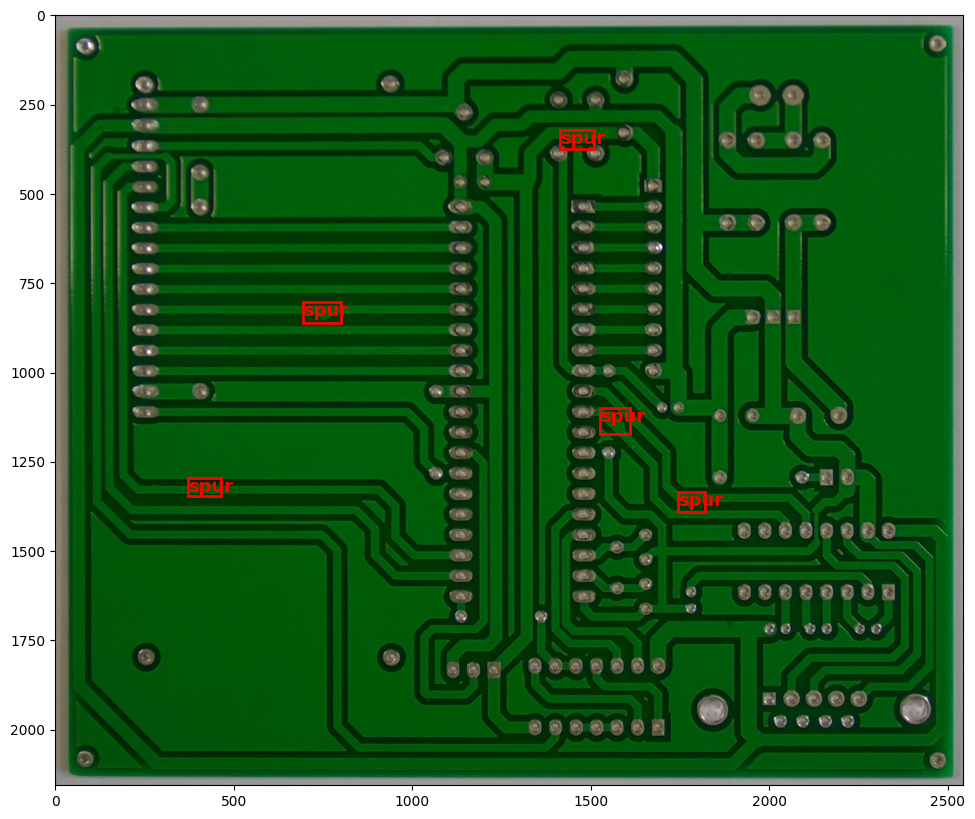

In [ ]:
img, tar, _ = fcb_dataset[random.randint(0,50)]
bbox = tar['boxes']
fig,ax = plt.subplots(figsize=(18,10))
ax.imshow(img.permute(1,2,0).cpu().numpy())
for j in tar["labels"].tolist():
    classes_la = {0:"missing_hole", 1: "mouse_bite", 2:"open_circuit",3: "short", 4:'spur',5:'spurious_copper'}
    l = classes_la[j]
    for i in range(len(bbox)):
        box = bbox[i]
        x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=2,edgecolor='r',facecolor='none',)
        ax.text(*box[:2], l, verticalalignment='top', color='red', fontsize=13, weight='bold')
        ax.add_patch(rect)
    plt.show()

In [ ]:
len(df)


2362

In [ ]:
image_ids = df['file'].unique()
valid_ids = image_ids[-665:]
train_ids = image_ids[:-665]
valid_df = df[df['file'].isin(valid_ids)]
train_df = df[df['file'].isin(train_ids)]
train_df.shape,valid_df.shape

((91, 8), (2271, 8))

In [ ]:
path


'/content/drive/MyDrive/PCB DEFECT DATASET/PCB_DATASET/images/'

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
train_dataset = fcbData(df, path, get_train_transform())
valid_dataset = fcbData(df, path, get_valid_transform())

# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=6,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=6,
    collate_fn=collate_fn
)


In [ ]:
next(iter(train_data_loader))

((tensor([[[0.6118, 0.6157, 0.6275,  ..., 0.6314, 0.6275, 0.6196],
           [0.6000, 0.6039, 0.6078,  ..., 0.6275, 0.6353, 0.6275],
           [0.6039, 0.6157, 0.6000,  ..., 0.6353, 0.6235, 0.6196],
           ...,
           [0.5882, 0.6000, 0.6078,  ..., 0.6039, 0.6314, 0.6118],
           [0.5765, 0.6000, 0.6118,  ..., 0.6039, 0.6196, 0.5961],
           [0.5882, 0.6000, 0.6078,  ..., 0.6078, 0.6000, 0.6000]],
  
          [[0.5882, 0.5922, 0.6039,  ..., 0.6118, 0.6078, 0.6000],
           [0.5765, 0.5804, 0.5843,  ..., 0.6078, 0.6157, 0.6078],
           [0.5804, 0.5922, 0.5765,  ..., 0.6157, 0.6039, 0.6000],
           ...,
           [0.5647, 0.5765, 0.5843,  ..., 0.5961, 0.6235, 0.6039],
           [0.5529, 0.5765, 0.5882,  ..., 0.5961, 0.6118, 0.5882],
           [0.5647, 0.5765, 0.5843,  ..., 0.6000, 0.5922, 0.5922]],
  
          [[0.5961, 0.6000, 0.6118,  ..., 0.6275, 0.6235, 0.6157],
           [0.5843, 0.5882, 0.5922,  ..., 0.6235, 0.6314, 0.6235],
           [0.5882, 0.

In [ ]:
num_classes = 6


model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)



in_features = model.roi_heads.box_predictor.cls_score.in_features


model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.0001, weight_decay=0.0005,)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


In [ ]:
num_epochs = 20

In [ ]:
train_data_loader

In [ ]:
import sys
best_epoch = 0
min_loss = sys.maxsize

for epoch in range(num_epochs):
    tk = tqdm(train_data_loader)
    model.train();
    for images, targets, image_ids in tk:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        tk.set_postfix(train_loss=loss_value)
    tk.close()

    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_value}")

    #validation
    model.eval();
    with torch.no_grad():
        tk = tqdm(valid_data_loader)
        for images, targets, image_ids in tk:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            val_output = model(images)
            val_output = [{k: v.to(device) for k, v in t.items()} for t in val_output]
            IOU = []
            for j in range(len(val_output)):
                a,b = val_output[j]['boxes'].cpu().detach(), targets[j]['boxes'].cpu().detach()
                chk = torchvision.ops.box_iou(a,b)
                res = np.nanmean(chk.sum(axis=1)/(chk>0).sum(axis=1))
                IOU.append(res)
            tk.set_postfix(IoU=np.mean(IOU))
        tk.close()

  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #0 loss: 0.12293501336475231


  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #1 loss: 0.11586639423271038


  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #2 loss: 0.10843091596265651


  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #3 loss: 0.11157971013685085


  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #4 loss: 0.10662405331035472


  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #5 loss: 0.1064688502659402


  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #6 loss: 0.1146461157908044


  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #7 loss: 0.12899793822666025


  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #8 loss: 0.11088041354318477


  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #9 loss: 0.11386400599380352


  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #10 loss: 0.11540216345687725


  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #11 loss: 0.1116152047028146


  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #12 loss: 0.11958192427059032


  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #13 loss: 0.10656950015922405


  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #14 loss: 0.10403607178827144


  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #15 loss: 0.10672082145114757


  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #16 loss: 0.1271900399436555


  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #17 loss: 0.11309993405242778


  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #18 loss: 0.11929371346135952


  0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #19 loss: 0.12692898650070047


  0%|          | 0/688 [00:00<?, ?it/s]

In [ ]:
img,target,_ = valid_dataset[3]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]

print('predicted #boxes: ', len(prediction['boxes']))
print('real #boxes: ', len(target['boxes']))

predicted #boxes:  17
real #boxes:  4


In [ ]:
torch.save(model.state_dict(), 'pcbdetection2.pt')

In [ ]:
y_true = []
y_pred = []

for i in range(len(valid_dataset)):
    img, target, _ = valid_dataset[i]
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])

        if len(prediction[0]['labels']) > 0:
            y_pred.append(prediction[0]['labels'][0].item())
        else:
            y_pred.append(-1)  # Using -1 to represent no prediction

        if len(target['labels']) > 0:
            y_true.append(target['labels'][0].item())
        else:
            y_true.append(-1)  # Using -1 to represent no ground truth label

# Print the collected true and predicted labels
print("True Labels:", y_true)
print("Predicted Labels:", y_pred)

True Labels: [1, 0, 1, 5, 0, 0, 5, 1, 4, 2, 0, 3, 5, 0, 1, 3, 4, 1, 0, 3, 3, 4, 4, 5, 5, 5, 0, 4, 1, 3, 4, 5, 4, 1, 1, 0, 0, 5, 5, 0, 5, 0, 1, 3, 0, 3, 2, 4, 4, 5, 5, 1, 1, 0, 3, 0, 3, 2, 2, 0, 1, 2, 1, 0, 3, 3, 0, 3, 1, 0, 2, 4, 3, 5, 5, 4, 5, 2, 1, 0, 0, 2, 5, 1, 0, 4, 4, 3, 4, 1, 5, 4, 0, 2, 0, 0, 3, 0, 5, 0, 5, 1, 4, 4, 1, 1, 1, 3, 3, 4, 2, 3, 4, 2, 3, 4, 3, 0, 5, 0, 4, 1, 5, 2, 5, 2, 4, 0, 5, 4, 0, 2, 4, 3, 2, 0, 1, 1, 3, 3, 1, 5, 5, 1, 1, 2, 4, 4, 4, 3, 0, 2, 3, 5, 2, 5, 2, 3, 1, 4, 4, 4, 0, 1, 5, 3, 5, 2, 5, 4, 3, 0, 2, 0, 2, 3, 3, 1, 2, 0, 1, 2, 5, 4, 2, 3, 0, 5, 2, 5, 1, 4, 5, 0, 1, 4, 4, 0, 3, 0, 5, 0, 0, 2, 3, 4, 4, 3, 3, 1, 3, 0, 1, 4, 3, 2, 5, 5, 3, 2, 1, 3, 4, 2, 4, 2, 4, 1, 5, 0, 3, 0, 5, 2, 0, 4, 0, 3, 2, 1, 3, 2, 4, 2, 3, 0, 2, 3, 1, 1, 2, 1, 3, 5, 1, 1, 5, 1, 4, 5, 0, 3, 3, 1, 0, 1, 1, 2, 1, 1, 5, 1, 2, 1, 2, 0, 1, 0, 2, 1, 1, 3, 4, 2, 1, 3, 1, 5, 5, 5, 0, 2, 4, 0, 0, 5, 4, 0, 0, 1, 1, 4, 4, 0, 1, 3, 2, 5, 1, 2, 5, 5, 1, 4, 0, 2, 2, 4, 0, 1, 3, 2, 1, 5, 5, 5, 2, 0, 5,

In [ ]:
yy_pred = []
for v in y_pred:
    yy_pred.append(v)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true, yy_pred)

array([[  0,   0,   0,   0,   0,   0,   0],
       [ 55,   0,  32,   0,   6,   3,  19],
       [  0,   0, 115,   0,   0,   0,   0],
       [  0,   0,   0, 115,   0,   0,   0],
       [  0,   0,   1,   0, 115,   0,   0],
       [  0,   0,   0,   0,   0, 112,   0],
       [  0,   0,   0,   0,   0,   2, 113]])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, yy_pred))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00       115
           1       0.78      1.00      0.87       115
           2       1.00      1.00      1.00       115
           3       0.95      0.99      0.97       116
           4       0.96      1.00      0.98       112
           5       0.86      0.98      0.91       115

    accuracy                           0.83       688
   macro avg       0.65      0.71      0.68       688
weighted avg       0.76      0.83      0.79       688



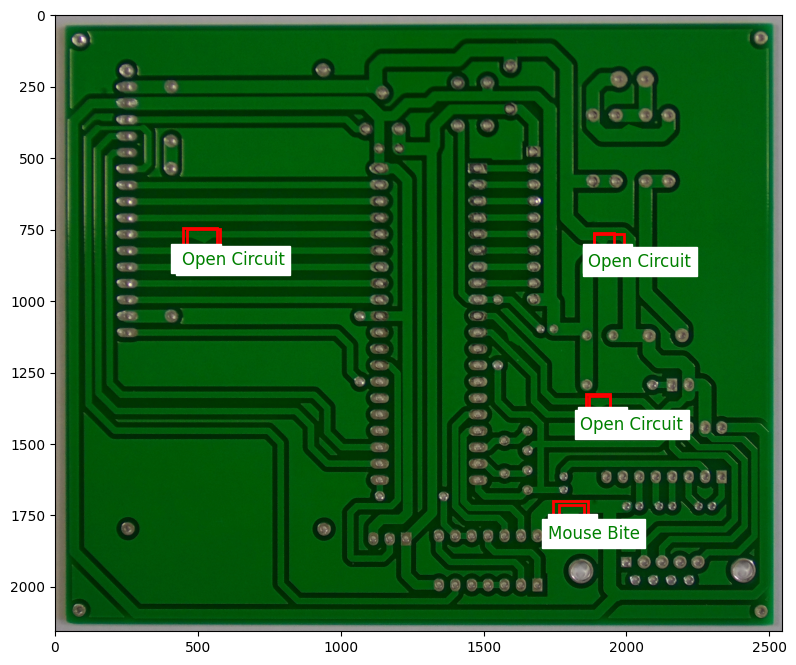

In [ ]:
# Define the device for inference (CPU or GPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

defect_names = {
0: "Missing Hole",
1: "Open Circuit",
2: "Short Circuit",
3: "Mouse Bite",
4: "Spur",
5: "Copper Trace Cut"
}
# Load the model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, num_classes=6)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=6)
model.load_state_dict(torch.load('/content/pcbdetection1.pt'))
model.eval()
model.to(device)

# Load the image
image_path = '/content/drive/MyDrive/PCB DEFECT DATASET/PCB_DATASET/images/Spur/05_spur_04.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image / 255.0

# Define the transformation to apply to the image
transform = T.Compose([T.ToTensor()])

# Apply the transformation to the image
image = transform(image).to(device)

# Predict the bounding boxes and labels for the image
image = image.float()
outputs = model([image])
boxes = outputs[0]['boxes'].detach().cpu().numpy()
labels = outputs[0]['labels'].detach().cpu().numpy()

# Visualize the image and the predicted bounding boxes
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(image.permute(1, 2, 0).cpu().numpy())
for box, label in zip(boxes, labels):
    x1, y1, x2, y2 = box
    w, h = x2 - x1, y2 - y1
    rect = matplotlib.patches.Rectangle((x1, y1), w, h, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(x1-20, y2 + 50, defect_names[label], fontsize=12, color='g', backgroundcolor='w')
plt.show()